In [20]:
import gym
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from collections import deque

print("gym: ", gym.__version__)
print("tensorflow: ", tf.__version__)

gym:  0.15.3
tensorflow:  1.14.0


In [21]:
env = gym.make("CartPole-v0")
print("Observation space: ", env.observation_space)
print("Action space: ", env.action_space)

Observation space:  Box(4,)
Action space:  Discrete(2)


In [22]:
class QNetwork():
    def __init__(self, state_dim, action_size, tau = 0.01):
        tf.reset_default_graph()
        self.state_in = tf.placeholder(tf.float32, shape = [None, *state_dim])
        self.action_in = tf.placeholder(tf.int32, shape = [None])
        self.q_target = tf.placeholder(tf.float32, shape = [None])
        action_one_hot = tf.one_hot(self.action_in, depth = action_size)
        
        self.q_state_local = self.build_model(action_size, "local")
        self.q_state_target = self.build_model(action_size, "target")
        
        self.local_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = "local")
        self.target_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = "target")
        
        self.q_state_action = tf.reduce_sum( tf.multiply(self.q_state_local, action_one_hot), axis = 1)
         
        self.loss = tf.reduce_mean(tf.square((self.q_target - self.q_state_action)))
        self.optimizer = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(self.loss)
        self.updater = tf.group( [ tf.assign(t, t + tau*(l-t)) for t, l in zip(self.target_vars, self.local_vars) ] )
        
    def build_model(self, action_size, scope):
        with tf.variable_scope(scope):
            hidden_1 = tf.layers.dense(self.state_in, 100, activation = tf.nn.relu)
            q_state = tf.layers.dense(hidden_1, action_size, activation = None)
            return q_state
        
    def get_q_state(self, sess, state, use_target=False):
        q_state_op = self.q_state_target if use_target else self.q_state_local
        q_state = sess.run(q_state_op, feed_dict = {self.state_in: state})
        return q_state
    
    def update_model(self, sess, state, action, q_target):
        feed = {self.state_in: state, self.action_in: action, self.q_target: q_target}
        sess.run([self.optimizer, self.updater], feed_dict = feed)
        

In [23]:
class replay_buffer():
    def __init__(self, maxlen):
        self.buffer = deque(maxlen = maxlen)
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        sample_size = min(len(self.buffer), batch_size)
        samples = random.choices(self.buffer, k = sample_size)
        return map(list, zip(*samples))
        

In [24]:
class Agent():
    def __init__(self, env):
        self.state_dim = env.observation_space.shape
        self.action_size = env.action_space.n
        print("action size: ", self.action_size)
        
        #self.build_model()
        self.q_network = QNetwork(self.state_dim, self.action_size)
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        self.gamma = 0.97
        self.eps = 1.0
        self.replay_buffer = replay_buffer(10000)
        
    '''
    def build_model(self):
        self.weights = 1e-4*np.random.rand(*self.state_dim, self.action_size)
        self.best_reward = -np.Inf
        self.best_weights = np.copy(self.weights) 
        self.noice_scale = 1e-2
    '''    
    def get_action(self, state):
        q_state = self.q_network.get_q_state(self.sess, [state])
        #p = np.dot(state, self.weights)
        action_greedy = np.argmax(q_state)
        action_random = np.random.randint(self.action_size)
        action = action_random if random.random()<self.eps else action_greedy
        return action
    
    def train(self, state, action, next_state, reward, done, use_DDQN=True):
        self.replay_buffer.add((state, action, next_state, reward, done))
        states, actions, next_states, rewards, dones = self.replay_buffer.sample(50)
        
        next_actions = np.argmax( self.q_network.get_q_state(self.sess, next_states, use_target=False), axis = 1)
        q_next_states= self.q_network.get_q_state(self.sess, next_states, use_target=use_DDQN)
        q_next_states[dones]= np.zeros([self.action_size])
        q_next_states_next_actions = q_next_states[np.arange(next_actions.shape[0] ), next_actions]
        
        q_targets = rewards + self.gamma*q_next_states_next_actions
        self.q_network.update_model(self.sess, states, actions, q_targets)
        if done:
            self.eps = max(0.1, self.eps*0.99)
    
    def __del__(self):
        self.sess.close()
    '''
    def update_model(self, reward):
        if reward > self.best_reward:
            self.best_reward = reward
            self.best_weights = np.copy(self.weights)
            self.noice_scale = max(self.noice_scale/2, 1e-3)
        else:
            self.noice_scale *= min(self.noice_scale*2, 2)
            
        self.weights = self.best_weights + self.noice_scale * np.random.rand(*self.state_dim, self.action_size)
    '''

In [27]:
num_runs = 10
run_rewards = [ ]

for n in range(num_runs):
    print("Run {}".format(n))
    ep_rewards = [ ]
    
    agent = None
    agent = Agent(env)
    for ep in range(200):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = agent.get_action(state)
            next_state, reward, done, info = env.step(action)
            agent.train(state, action, next_state, reward, done, use_DDQN = (n%2 == 0))
            total_reward += reward
            #env.render()
            state = next_state
        #agent.update_model(total_reward)
        #print("episode: ", ep, "total reward: ", total_reward)
        ep_rewards.append(total_reward)
    run_rewards.append(ep_rewards)


Run 0
action size:  2
Run 1
action size:  2
Run 2
action size:  2
Run 3
action size:  2
Run 4
action size:  2
Run 5
action size:  2
Run 6
action size:  2
Run 7
action size:  2
Run 8
action size:  2
Run 9
action size:  2


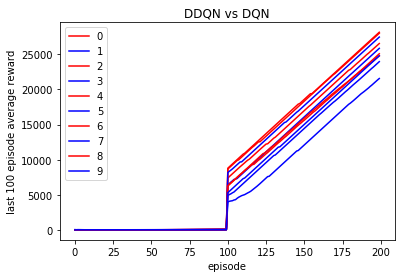

In [28]:
for n, ep_rewards in enumerate(run_rewards):
    x = range(len(ep_rewards))
    cumsum = np.cumsum(ep_rewards)
    avgs = [cumsum[ep]/(ep+1) if ep<100 else cumsum[ep] - cumsum[ep-100]/100 for ep in x]
    col = "r" if (n%2 == 0) else "b"
    plt.plot(x, avgs, color = col, label = n)
    
plt.title("DDQN vs DQN")
plt.xlabel("episode")
plt.ylabel("last 100 episode average reward")
plt.legend()
    